# Forecast value assessment for reservoir operations and drought management


Overall, this Python code is designed to assess the forecast value of flow scenarios or forecasts through four steps, as outlined below. Before assessing forecast value, deterministic or ensemble flow forecasts, such as Seasonal Flow Forecasts (SFFs) or Ensemble Streamflow Prediction (ESP), should be generated. Utilizing the SEAFORM and SEAFLOW toolboxes can assist in this process.

![simulation_process](util/images/flowchart.jpg)

# 1.a. Initial reservoir release schedule optimisation

This example enables reservoir operations and decision-making for release scheduling during drought events. As shown in the figure below, the simulation is continuously conducted over the entire simulation period using a specified decision-making time step (monthly or bimonthly). Flow scenario/forecast used in this example includes perfect forecast, worst-case drought scenario, 20-year return period drought secnario, Ensemble Streamflow Prediction (ESP), and Seasonal Flow Forecasts (SFFs).

This Jupyter Notebook facilitates the initial optimisation of release schedules and generates weekly release schedule Pareto front for each flow scenario/forecast.

![simulation process](util/images/simulation-process.jpg)

## 1. Import libraries

As a first step, this notebook provides the initial reservoir simulation starting with observed storage. Now, we need to import the necessary libraries and tools (🚨 in order to run the code like in the box below, place the mouse pointer in the cell, then click on “run cell” button above or press shift + enter).

In [38]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from platypus import NSGAII, Problem, Real
import warnings
warnings.filterwarnings('ignore')
import datetime
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
import calendar
from datetime import date
from dateutil.relativedelta import relativedelta
from irons.Software.read_data import read_csv_data
from irons.Software.day2week2month import day2week
from irons.Software.res_sys_sim import res_sys_sim
path = os.getcwd()

## 2. Check flow scenarios or forecasts

Before conducting actual reservoir simulations, it is essential to verify the flow scenario and forecast data. The following code snippet reads inflow data from the data folder and calculates the cumulative inflow for the upcoming 7 months.

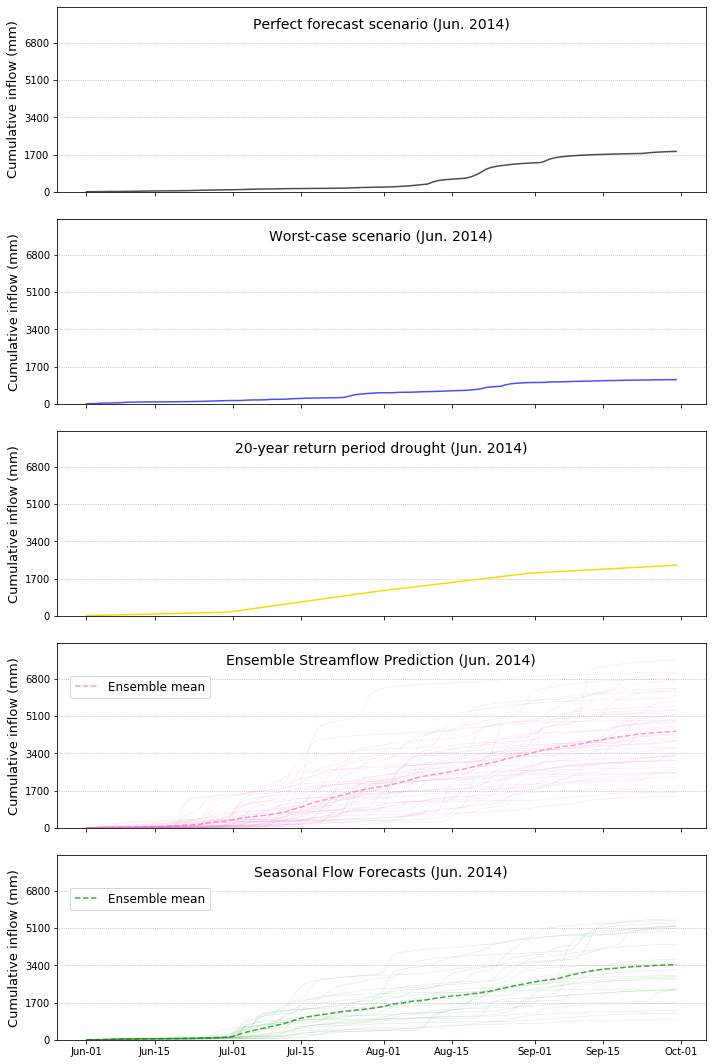

In [39]:
# Define the flow scenario/forecast and MCDM method used in the analysis
scenario_list = {1:'1. Perfect forecast scenario', 2:'2. Worst case scenario', 3:'3. 20-year drought', 4:'4. ESP', 5:'5. SFFs'} 
MCDM_list = {1:'saw_bal', 2:'saw_sup', 3:'saw_sto', 4:'vw_select', 5:'vw_multi', 6:'rp_utopia', 7:'rp_knee', 8:'rp_topsis'}

# Define the specific year and month that you want to check
year  = 2014
month = 6
leadtime = 4

# Read flow scenario and forecast data
flow1 =  pd.read_csv(path + '/data/' + scenario_list[1] + '/in/leadtime_' + str(leadtime) + '/I_fore_' + str(year) + '_' + str(month) + '.csv')
flow2 =  pd.read_csv(path + '/data/' + scenario_list[2] + '/in/leadtime_' + str(leadtime) + '/I_fore_' + str(year) + '_' + str(month) + '.csv')
flow3 =  pd.read_csv(path + '/data/' + scenario_list[3] + '/in/leadtime_' + str(leadtime) + '/I_fore_' + str(year) + '_' + str(month) + '.csv')
flow4 =  pd.read_csv(path + '/data/' + scenario_list[4] + '/in/leadtime_' + str(leadtime) + '/I_fore_' + str(year) + '_' + str(month) + '.csv')
flow5 =  pd.read_csv(path + '/data/' + scenario_list[5] + '/in/leadtime_' + str(leadtime) + '/I_fore_' + str(year) + '_' + str(month) + '.csv')

# Set figure y-axis lower & upper limits and interval
y_LL = 0
y_UL = int(max(np.cumsum(flow.iloc[:, 1:], axis=0).iloc[-1, :].max() for flow in [flow1, flow2, flow3, flow4])*1.1)
y_interval = round(y_UL/5, -2)

fig, ax = plt.subplots(5, 1, figsize=(10*1, 3*5))
#------------------------------------------Inflow------------------------------------------------------------------
plt.subplot(5,1,1)
flow1['Date'] = pd.to_datetime(flow1['Date'], infer_datetime_format=True, format='%d/%m/%Y', errors='ignore')

plt.plot(flow1.Date.values, np.cumsum(flow1['I']), lw=1.5, ls='-', color='black', alpha=0.7, 
        label='Perfec forecast scenario')

plt.tick_params(axis="both", which="both", bottom=True, top=False, left=True, right=False, 
                labelbottom=True, labelleft=True, length=4)        
plt.grid(True, axis='y', linestyle=':') 
plt.title('Perfect forecast scenario (' + calendar.month_abbr[month] + '. ' + str(year) + ')', x=0.5, y=0.85, fontsize=14, backgroundcolor='white')
plt.ylim(y_LL, y_UL)  # Set y-axis limits
plt.ylabel('Cumulative inflow (mm)', fontsize=13)

ax = plt.gca()
dateFmt = mdates.DateFormatter('%b-%d')
ax.xaxis.set_major_formatter(dateFmt)
ax.yaxis.set_major_locator(MultipleLocator(y_interval))
ax.axes.xaxis.set_ticklabels([])


plt.subplot(5,1,2)
flow2['Date'] = pd.to_datetime(flow2['Date'], infer_datetime_format=True, format='%d/%m/%Y', errors='ignore')

plt.plot(flow2.Date.values, np.cumsum(flow2['I']), lw=1.5, ls='-', color='blue', alpha=0.7, 
        label='Worst-case scenario')

plt.grid(True, axis='y', linestyle=':') 

# Define date format
ax = plt.gca()
dateFmt = mdates.DateFormatter('%b-%d')
ax.xaxis.set_major_formatter(dateFmt)
ax.yaxis.set_major_locator(MultipleLocator(y_interval))
ax.axes.xaxis.set_ticklabels([])
plt.title('Worst-case scenario (' + calendar.month_abbr[month] + '. ' + str(year) + ')', x=0.5, y=0.85, fontsize=14, backgroundcolor='white')
plt.ylim(y_LL, y_UL)  # Set y-axis limits
plt.ylabel('Cumulative inflow (mm)', fontsize=13)


plt.subplot(5,1,3)
flow3['Date'] = pd.to_datetime(flow3['Date'], infer_datetime_format=True, format='%d/%m/%Y', errors='ignore')

plt.plot(flow3.Date.values, np.cumsum(flow3['I']), lw=1.5, ls='-', color='gold', alpha=1, 
        label='Worst-case scenario')

plt.grid(True, axis='y', linestyle=':') 

# Define date format
ax = plt.gca()
dateFmt = mdates.DateFormatter('%b-%d')
ax.xaxis.set_major_formatter(dateFmt)
ax.yaxis.set_major_locator(MultipleLocator(y_interval))
ax.axes.xaxis.set_ticklabels([])
plt.title('20-year return period drought (' + calendar.month_abbr[month] + '. ' + str(year) + ')', x=0.5, y=0.85, fontsize=14, backgroundcolor='white')
plt.ylim(y_LL, y_UL)  # Set y-axis limits
plt.ylabel('Cumulative inflow (mm)', fontsize=13)

plt.subplot(5,1,4)
flow4['Date'] = pd.to_datetime(flow4['Date'], infer_datetime_format=True, format='%d/%m/%Y', errors='ignore')

columns = flow4.columns[1:]
num_columns = len(flow4.columns) - 1  # Excluding the 'date' column
mycolors = ['tab:pink'] * num_columns  # Create a list of 'tab:grey' repeated num_columns times
        
for i, column in enumerate(columns[:]):  # plot the forecast ensemble members  
    plt.plot(flow4.Date.values, np.cumsum(flow4[column].values), lw=0.5, color=mycolors[i], alpha=0.2)
plt.plot(flow4.Date.values, np.cumsum(flow4.mean(axis=1)), lw=1.5, ls='--', color='hotpink', alpha=0.7, 
        label='Ensemble mean')

plt.grid(True, axis='y', linestyle=':') 

# Define date format
ax = plt.gca()
dateFmt = mdates.DateFormatter('%b-%d')
ax.xaxis.set_major_formatter(dateFmt)
ax.yaxis.set_major_locator(MultipleLocator(y_interval))
ax.axes.xaxis.set_ticklabels([])
plt.title('Ensemble Streamflow Prediction (' + calendar.month_abbr[month] + '. ' + str(year) + ')', x=0.5, y=0.85, fontsize=14, backgroundcolor='white')
plt.ylim(y_LL, y_UL)  # Set y-axis limits
plt.ylabel('Cumulative inflow (mm)', fontsize=13)
plt.legend(fontsize=12, loc=(0.02, 0.70))

plt.subplot(5,1,5)
flow5['Date'] = pd.to_datetime(flow5['Date'], infer_datetime_format=True, format='%d/%m/%Y', errors='ignore')

columns = flow5.columns[1:]
num_columns = len(flow5.columns) - 1    # Excluding the 'date' column
mycolors = ['tab:green'] * num_columns  # Create a list of 'tab:grey' repeated num_columns times
        
for i, column in enumerate(columns[:]):  # plot the forecast ensemble members  
    plt.plot(flow5.Date.values, np.cumsum(flow5[column].values), lw=0.5, color=mycolors[i], alpha=0.2)
plt.plot(flow5.Date.values, np.cumsum(flow5.mean(axis=1)), lw=1.5, ls='--', color='green', alpha=0.7, 
        label='Ensemble mean')

# Add grid lines
plt.grid(True, axis='y', linestyle=':') 
# Define date format
ax = plt.gca()
dateFmt = mdates.DateFormatter('%b-%d')
ax.xaxis.set_major_formatter(dateFmt)
ax.yaxis.set_major_locator(MultipleLocator(y_interval))
plt.title('Seasonal Flow Forecasts (' + calendar.month_abbr[month] + '. ' + str(year) + ')', x=0.5, y=0.85, fontsize=14, backgroundcolor='white')
plt.ylim(0, y_UL)  # Set y-axis limits
plt.ylabel('Cumulative inflow (mm)', fontsize=13)

plt.legend(fontsize=12, loc=(0.02, 0.70))

plt.tight_layout(w_pad=2, h_pad = 1.0)
plt.show()


## 3. Reservoir simulation settings

Once the flow scenario and forecast data have been verified, it is necessary to specify the details of the reservoir simulations, including parameters such as storage names, capacity constraints, and release constraints.

In [49]:
# Define reservoir characteristic
reservoir_name = 'A'
s_min = 337               # Minimum Storage volume (Million Cubic Meters)
s_max = 4349              # Maximum Storage volume (Million Cubic Meters)
Q_max = 652               # Maximum regulated release (Million Cubic Meters/day)
env_min = 0               # Minimum environmental release (MCM/d)
Qreg_s_D_min = 0          # Minumum regulated release (MCM/d)
Qreg_s_D_max = Q_max      # Maximum regulated release (MCM/d)

# Details on the initial reservoir release optimisation
start_year = 2014
start_month = 6
leadtime = 4              # 2, 4, 6 months
decision_time = 2         # 1 (monthly) or 2 (bimonthly)

# Release optimisation options
pop = 100        # Number of release options
itnum = 50000   # Number of iteration

## 4. Release schedule optimisation

Reservoir operations inherently involve managing multiple objectives often in conflict with each other (Zhou et al., 2011; Vassoney et al., 2021). In terms of drought management, the amount of supply deficit shows an inverse correlation with both the secured reservoir storage at the initial stage of the hydrological year (October 1st) and the total inflow into the reservoir across the hydrological year (from October 1st to the subsequent September 30th). In other words, inadequate storage at the outset of the hydrological year leads to substantial disruptions in water supply and the severity of these shortages further increases when the inflow is insufficient.
To address this relationship in reservoir simulations, we established two operational objectives: the mean Squared Supply Deficit (SSD, [million m3]2) over the drought event and the Storage Volume Difference (SVD, million m3) relative to the reservoir's capacity by the end of the hydrological year. The rationale for squaring the supply deficit is to incorporate risk hedging principles, aimed at strategically allocating water resources over time (You, 2013; Shiau, 2022). These two objectives are formulated as:

$$
SSD = \frac{1}{T} \sum_{t=0}^{T} \left[ \max(0, d(t) - Q(t)) \right]^2
$$



$$
SVD = \max(0, S_{\text{max}} - S)
$$

where T is the total number of weeks for which the flow forecast is available (i.e. T equals the lead time in months × 4), d(t) and Q(t) represent water demand and supply at time t (week), respectively. S_max  is the storage capacity of the reservoir (million m3) and S is the simulated storage volume (million m3) at the end of the hydrological year. When the end of hydrological year is not included in the simulation period, S is set to the storage at the end of the simulation. By definition, superior performance is associated with smaller objectives (SSD and SSD). 


iRONS incorporates an optimiser that utilises the Non-dominated Sorting Genetic Algorithm (NSGA-Ⅱ) for the multi-objective optimisation. Given that in multi-objective optimisation problems, a single optimal solution that satisfies all objectives simultaneously is unattainable (Lu et al., 2011; Malekmohammadi et al., 2011), NSGA-II identifies a set of non-dominated solutions whose performance realise different Pareto optimal trade-offs between the two objectives. The performances associated with these solutions visualised in the objective space constitute the so called “Pareto front” (Giagkiozis and Fleming, 2014; Ni et al., 2022). 
Derived Pareto front comprises one hundred non-dominated solutions for weekly release scheduling up to the next decision-making time step. When optimising against ensemble forecasts, the two objective functions (SSD and SVD) are evaluated against each ensemble members, and the average is taken as the final objective value and passed on to the NSGA-II optimiser.

For more details regarding theoretical background, please refer to following paper.
* Lee, Y., Peñuela, A., Pianosi, F., and Angel Rico-Ramirez, M.: Value of seasonal flow forecasts for enhancing reservoir operation and drought management in South Korea, EGUsphere [preprint], https://doi.org/10.5194/egusphere-2024-1985, 2024.


The code for optimizing reservoir release schedules depends on the type of input flow scenario or forecast. For deterministic input data, such as worst-case scenarios, use the reservoir_opt_deterministic function. For ensemble-based inputs, such as Ensemble Streamflow Prediction (ESP) or Seasonal Flow Forecasts (SFFs), use the reservoir_opt_probabilistic function. <b>You only need to execute the following two code snippets</b>.

In [4]:
def reservoir_opt_deterministic_example(reservoir_name, month, year, leadtime, pop, itnum, scenario):
    
    # Define input and output file paths based on scenario and leadtime
    input_path = path + '/data/' + scenario_list[scenario] + '/in/leadtime_' + str(leadtime) + '/'  # Path for forecast data
    observation_path = path + '/data/' + scenario_list[1] + '/in/leadtime_' + str(leadtime) + '/'  # Path for observation data    
    output_path = path + '/data/' + scenario_list[scenario] + '/out/leadtime_' + str(leadtime) + '/' + MCDM_list[MCDM] + '/'  # Output path

    # Read potential evapotranspiration forecasts (mm/d)
    e_fore_file = 'e_fore_' + str(year) + '_' + str(month) + '.csv'
    dates_fore_day, e_fore_day = read_csv_data(input_path, e_fore_file)
    dates_fore, e_fore_ens, e_fore_cum_ens = day2week(dates_fore_day, e_fore_day)
    e_fore = np.zeros((dates_fore.shape[0], 1))
    e_fore[:, 0] = e_fore_ens.mean(1)   # Compute average of the forecast ensemble
    
    # Read potential evapotranspiration observations (mm/d)
    e_obs_file = 'e_fore_' + str(year) + '_' + str(month) + '.csv'
    dates_obs_day, e_obs_day = read_csv_data(observation_path, e_obs_file)
    dates_obs, e_obs_ens, e_obs_cum_ens = day2week(dates_obs_day, e_obs_day)
    e_obs = np.zeros((dates_obs.shape[0], 1))
    e_obs[:, 0] = e_obs_ens.mean(1)      # Compute average of the observation ensemble

    # Read inflow forecasts (mm/d)
    I_fore_file = 'I_fore_' + str(year) + '_' + str(month) + '.csv'
    dates_fore_day, I_fore_day = read_csv_data(input_path, I_fore_file)
    dates_fore, I_fore_ens, I_fore_cum_ens = day2week(dates_fore_day, I_fore_day)
    I_fore = np.zeros((dates_fore.shape[0], 1))
    I_fore[:, 0] = I_fore_ens.mean(1)      # Compute average of the forecast ensemble

    # Read inflow observations (mm/d)
    I_obs_file = 'I_fore_' + str(year) + '_' + str(month) + '.csv'
    dates_obs_day, I_obs_day = read_csv_data(observation_path, I_obs_file)
    dates_obs, I_obs_ens, I_obs_cum_ens = day2week(dates_obs_day, I_obs_day)
    I_obs = np.zeros((dates_obs.shape[0], 1))
    I_obs[:, 0] = I_obs_ens.mean(1)         # Compute average of the observation ensemble

    # Read demand (fixed) (mm/d)
    d_fore_file = 'd_fore_' + str(year) + '_' + str(month) + '.csv'
    dates_fore_day, d_fore_day = read_csv_data(input_path, d_fore_file)
    dates_fore, d_fore_ens, d_fore_cum_ens = day2week(dates_fore_day, d_fore_day)
    d_fore = np.zeros((dates_fore.shape[0], 1))
    d_fore[:, 0] = d_fore_ens.mean(1)        # Compute average of the forecast ensemble

    # Read observation data and set initial storage (Million m3)
    obsdata = pd.read_csv(path + '/data/observed_data.csv', index_col='Date')
    obsdata.index = pd.to_datetime(obsdata.index)
    
    if year == start_year and month == start_month:
        ini_date = dates_fore[0]  # Set initial date to the first date of the weekly forecast
        s_ini = obsdata[obsdata.index == ini_date].iloc[0, 0]  # Initial storage from observation data
    else:
        # Set initial storage based on the scenario
        if scenario == 1:
            s_ini = S_all['S_pf'][len(S_all) - 1]
        elif scenario == 2:
            s_ini = S_all['S_wc'][len(S_all) - 1]
        elif scenario == 3:
            s_ini = S_all['S_d20'][len(S_all) - 1]
    
    M = 1  # Number of Ensemble (deterministic if M=1)
    N = dates_fore.shape[0]  # Number of forecast weeks
    
    # Define the target week for Storage Optimisation
    if month + leadtime < 10:
        target_week = N
    elif month >= 10:
        target_week = N
    else:
        target_week = N - 4 * (month + leadtime - 10)

    # Release optimisation parameters
    pop_size = pop  # Population size
    num_iter = itnum  # Number of iterations
    
    def auto_optim(vars):
        Qreg_s_D = np.zeros((N, 1))
        # Decision vector: regulated release to meet the demand in D
        Qreg_s_D[:, 0] = np.array(vars[0:N])
        Qreg = {'releases': {'type': 'scheduling',
                             'input': Qreg_s_D},
                'inflows': [],
                'rel_inf': []}
    
        # Reservoir system simulation
        Qenv, Qspill, Qreg_s_D, I_reg, s, E = res_sys_sim(I_fore, e_fore, s_ini, s_min, s_max,
                                                          env_min, d_fore, Qreg)
    
        # Objective functions
        SuDe = (np.maximum(d_fore - Qreg_s_D, 0))**2  # Supply deficit objective
        StDi = s_max - s  # Storage difference objective
        SSD = np.mean(SuDe[1:])  # Mean Squared Supply Deficit
        SVD = np.mean(StDi[target_week])  # Storage Volume Difference
    
        return [SSD, SVD]
    
    problem = Problem(N, 2)  # Define optimization problem (number of variables, number of objective functions)
    Real0 = Real(Qreg_s_D_min, Qreg_s_D_max)  # Define range of values
    
    problem.types[:] = [Real0] * (N)
    problem.function = auto_optim
    
    algorithm_1 = NSGAII(problem, pop_size)  # Initialize NSGA-II algorithm
    algorithm_1.run(num_iter)  # Run the algorithm
    
    sol_optim_1 = [algorithm_1.result[i].variables for i in range(pop_size)]  # Extract optimization results
    
    # Save the optimized release schedule
    rel_schedule = pd.DataFrame(sol_optim_1)
    rel_schedule = rel_schedule.transpose()
    rel_schedule['mean'] = rel_schedule.mean(numeric_only=True, axis=1)
    rel_schedule.to_csv(path + '/data/examples/' + scenario_list[scenario] + '/[opt_rel_schedule]' + reservoir_name + '_' + str(year) + '_' + str(month) 
                   + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv')
    
    # Save the results of the objectives
    results_SSD_1 = np.array([algorithm_1.result[i].objectives[0] for i in range(pop_size)])
    results_SVD_1 = np.array([algorithm_1.result[i].objectives[1] for i in range(pop_size)])
    
    SSD = pd.DataFrame(results_SSD_1).rename(columns={0: 'SSD'})  # Save SSD results
    SVD = pd.DataFrame(results_SVD_1).rename(columns={0: 'SVD'})  # Save SVD results
    SSD_SVD = pd.concat([SSD, SVD], axis=1)
    sim_pareto = SSD_SVD
    sim_pareto.to_csv(path + '/data/examples/' + scenario_list[scenario] + '/[sim_pareto]' + reservoir_name + '_' + str(year) + '_' + str(month) 
                   + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv')
            
    temp = pd.DataFrame()
    
    # Evaluate and save actual Pareto-front results
    for i in range(0, pop_size):
        Qreg_s_D_opt = np.reshape(sol_optim_1[i], (N, 1))
        # Decision vector: regulated release to meet the demand in D
    
        Qreg_opt = {'releases': {'type': 'scheduling',
                                 'input': Qreg_s_D_opt},
                    'inflows': [],
                    'rel_inf': []}
        
        Qenv, Qspill, Qreg_s_D_opt, I_reg, s, E = res_sys_sim(I_obs, e_obs, s_ini, s_min, s_max, 
                                                              env_min, d_fore, Qreg_opt)
        
        SuDe = (np.maximum(d_fore - Qreg_s_D_opt, 0))**2  # Supply deficit objective
        StDi = s_max - s  # Resource deficit objective
        SSD = np.mean(SuDe[1:])
        SVD = np.mean(StDi[target_week])
        
        output = pd.DataFrame(columns=['i', 'SSD', 'SVD'])
        output.loc[i] = [i, round(SSD, 3), round(SVD, 3)]
    
        temp = pd.concat([temp, output], axis=0)
    temp.set_index('i', inplace=True)
    act_pareto = temp
    act_pareto.to_csv(path + '/data/examples/' + scenario_list[scenario] + '/[act_pareto]' + reservoir_name + '_' + str(year) + '_' + str(month) 
                   + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv')
    
    # Operation data management -------------------------------------------------------------------------------------------------------------------------------------
    df = pd.read_csv(path + '/data/examples/' + scenario_list[scenario] + '/[opt_rel_schedule]' + reservoir_name + '_' + str(year) + '_' + str(month) 
                   + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col = [0])

    Iobs = df.copy()
    for i in range(0,pop_size):
        Iobs[str(i)] = I_obs
        Iobs['mean'] = I_obs
    
    Demand = df.copy()
    for i in range(0,pop_size):
        Demand[str(i)] = d_fore        
        Demand['mean'] = d_fore
        
    Sini = df.copy().drop(df.index[1:])
    for i in range(0,pop_size):
        Sini[str(i)] = s_ini
        Sini['mean'] = s_ini
        
    df_merge = pd.concat([df, Iobs, Demand, Sini], axis=0).reset_index(drop=True)
    
    for i in range(0,len(df)): #storage volume calculation
        df_merge.loc[len(df)*3+1+i] = np.minimum(df_merge.loc[len(df)*3+i] - df_merge.loc[i] + df_merge.loc[len(df)+i], s_max)
        
    for i in range(0,len(df)+1): #storage volume difference calculation
        df_merge.loc[len(df)*4+1+i] = s_max - df_merge.loc[len(df)*3+i]
        
    for i in range(0,len(df)): #supply deficit calculation
        df_merge.loc[len(df)*5+2+i] =  np.maximum(df_merge.loc[len(df)*2+i] - df_merge.loc[i],0)
        
    df_merge.loc[len(df)*6+2] = df_merge.iloc[len(df)*5+2:len(df)*6+2].sum() # supply deficit sum calculation
    df_merge.loc[len(df)*6+3] = df_merge.iloc[len(df)*4+2:len(df)*5+2].mean() # mean SVD
    df_merge.loc[len(df)*6+4] = df_merge.iloc[len(df)*5+3:len(df)*6+2].pow(2).mean() # mean SSD
    df_merge.loc[len(df)*6+5] = df_merge.iloc[len(df)*5+3:len(df)*6+2].pow(2).sum() # mean SSD
    
    df_merge['remark'] = np.NaN
    for i in range(0, len(df)):
        df_merge['remark'].loc[i] = 'Release'
        df_merge['remark'].loc[len(df) + i] = 'I_obs'
        df_merge['remark'].loc[len(df)*2 + i] = 'Demand'
        df_merge['remark'].loc[len(df)*3] = 'Initial Sotrage'
        df_merge['remark'].loc[len(df)*3 + 1 + i] = 'Storage'
    for i in range(0, len(df)+1):
        df_merge['remark'].loc[len(df)*4 + 1 + i] = 'Volume Difference'
        df_merge['remark'].loc[len(df)*5 + 1 + i+1] = 'Supply Deficit'
        df_merge['remark'].loc[len(df)*6 + 1+1] = 'Sum of Supply Deficit'
        df_merge['remark'].loc[len(df)*6 + 2+1] = 'mean SVD'
        df_merge['remark'].loc[len(df)*6 + 3+1] = 'mean SSD'
        df_merge['remark'].loc[len(df)*6 + 4+1] = 'sum SSD'
    df_merge = df_merge.set_index('remark')
    
    df_merge.to_csv(path + '/data/examples/' + scenario_list[scenario] + '/[Res_operation]' + reservoir_name + '_' + str(year) + '_' + str(month) 
                   + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv')

In [5]:
def reservoir_opt_probabilistic_example(reservoir_name,month,year,leadtime,pop, itnum, scenario):
    
    # Allocate input file paths
    input_path = path + '/data/' + scenario_list[scenario] + '/in/leadtime_' + str(leadtime) + '/' # folder containing the forecast weather data
    observation_path = path + '/data/' + scenario_list[1] + '/in/leadtime_' + str(leadtime) + '/' # folder containing the forecast weather data    
    output_path = path + '/data/' + scenario_list[scenario] + '/out/leadtime_' + str(leadtime) + '/' + MCDM_list[MCDM] + '/' # folder containing the forecast weather data
    
    # Read potential evapotranspiration forecasts (mm/d)
    e_fore_file = 'e_fore_' + str(year) + '_' + str(month) + '.csv'
    dates_fore_day, e_fore_day = read_csv_data(input_path, e_fore_file)
    dates_fore, e_fore_ens, e_fore_cum_ens = day2week(dates_fore_day, e_fore_day)
    e_fore = np.zeros((dates_fore.shape[0],1))
    e_fore[:,0] = e_fore_ens.mean(1)   # Average of the forecast ensemble
    
    # Read potential evapotranspiration observation (mm/d)
    e_obs_file = 'e_fore_' + str(year) + '_' + str(month) + '.csv'
    dates_obs_day, e_obs_day = read_csv_data(observation_path, e_obs_file)
    dates_obs, e_obs_ens, e_obs_cum_ens = day2week(dates_obs_day,e_obs_day)
    e_obs = np.zeros((dates_obs.shape[0],1))
    e_obs[:,0] = e_obs_ens.mean(1)      # Average of the forecast ensemble

    # Read inflow forecasts (mm/d)
    I_fore_file = 'I_fore_'  + str(year) + '_' + str(month) + '.csv'
    dates_fore_day, I_fore_day = read_csv_data(input_path, I_fore_file)
    dates_fore, I_fore_ens, I_fore_cum_ens = day2week(dates_fore_day,I_fore_day)
    I_fore = np.zeros((dates_fore.shape[0],1))
    I_fore[:,0] = I_fore_ens.mean(1)      # Average of the forecast ensemble

    # Read inflow observation (mm/d)
    I_obs_file = 'I_fore_'  + str(year) + '_' + str(month) + '.csv'
    dates_obs_day, I_obs_day = read_csv_data(observation_path, I_obs_file)
    dates_obs, I_obs_ens, I_obs_cum_ens = day2week(dates_obs_day,I_obs_day)
    I_obs = np.zeros((dates_obs.shape[0],1))
    I_obs[:,0] = I_obs_ens.mean(1)         # Average of the forecast ensemble

    # Read demand (fixed) (mm/d)
    d_fore_file = 'd_fore_'  + str(year) + '_' + str(month) + '.csv'
    dates_fore_day, d_fore_day = read_csv_data(input_path, d_fore_file)
    dates_fore, d_fore_ens, d_fore_cum_ens = day2week(dates_fore_day,d_fore_day)
    d_fore = np.zeros((dates_fore.shape[0],1))
    d_fore[:,0] = d_fore_ens.mean(1)        # Average of the forecast ensemble

    # Read observation data and set initial storage (Million m3)
    obsdata = pd.read_csv(path + '/data/observed_data.csv',index_col = 'Date')
    obsdata.index = pd.to_datetime(obsdata.index)
        
    if year == start_year and month == start_month :
        ini_date = dates_fore[0] # the initial date corresponds to the first date of the weekly forecast
        s_ini = obsdata[obsdata.index == ini_date].iloc[0,0]    
    else:
        if scenario == 1:
            s_ini = S_all['S_pf'][len(S_all)-1]
        elif scenario == 2:
            s_ini = S_all['S_wc'][len(S_all)-1]
        elif scenario == 3:
            s_ini = S_all['S_20yd'][len(S_all) - 1]
        elif scenario == 4:
            s_ini = S_all['S_esp'][len(S_all)-1]
        elif scenario == 5:
            s_ini = S_all['S_sffs'][len(S_all)-1]    
    
    M = I_fore_ens.shape[1] # M = Number of Ensemble or scenario
    N = dates_fore.shape[0]                 # Number of forecast weeks
    
    # Define the target week for Storage Optimisation
    if month + leadtime <10:
        target_week = N
    elif month >=10:
        target_week = N
    else:
        target_week = N - 4*(month + leadtime - 10)
    
    
    # Read observation data
    obsdata = pd.read_csv(path + '/data/observed_data.csv',index_col = 'Date')
    obsdata.index = pd.to_datetime(obsdata.index)
    
    # Release optimisation
    pop_size = pop   # population size
    num_iter = itnum # Number of iterations
    
    SSD = 0
    SVD = 0
                
    def auto_optim(vars):
        Qreg_S_D = np.array(vars[0:N]).reshape(N,1)
        # Decision vector: regulated release to meet the demand in D
        Qreg = {'releases' : {'type'  : 'scheduling',
                                'input' : Qreg_S_D},
                'inflows'  : [],
                'rel_inf'  : []}
                
        # Reservoir system simulation
        Qenv, Qspill, Qreg_S_D, I_reg, s, E = res_sys_sim(I_fore_ens,e_fore_ens, s_ini,s_min,s_max, 
                                                          env_min,d_fore, Qreg)
                
        # Objective functions
        SuDe = (np.maximum(d_fore_ens-Qreg_S_D,0))**2   # supply deficit objective
        StDi = s_max - s                            # resource deficit objective
        SSD = np.mean(np.mean(SuDe[1:,:],axis = 0))
        SVD = np.mean(np.mean(StDi[target_week,:],axis = 0))
                
        return [SSD, SVD]

    problem = Problem(N,2)                     # Problem(number of optimizer variables, num of objective functions)
    Real0 = Real(Qreg_s_D_min, Qreg_s_D_max)     # Range of values
    
    problem.types[:] = [Real0]*(N)
    problem.function = auto_optim
    
    algorithm_2 = NSGAII(problem,pop_size)
    algorithm_2.run(num_iter)
    
    sol_optim_2 = np.array([algorithm_2.result[i].variables for i in range(pop_size)])
    
    rel_schedule = pd.DataFrame(sol_optim_2)               # array? csv? ???? ?? ???? ?? ??? ????? ?????
    rel_schedule = rel_schedule.transpose()
    rel_schedule['mean'] = rel_schedule.mean(numeric_only=True, axis=1)
    rel_schedule.to_csv(path + '/data/examples/' + scenario_list[scenario] + '/[opt_rel_schedule]' + reservoir_name + '_' + str(year) + '_' + str(month) 
                   + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv')
    
    results_SSD_2 = np.array([algorithm_2.result[i].objectives[0] for i in range(pop_size)])
    results_SVD_2 = np.array([algorithm_2.result[i].objectives[1] for i in range(pop_size)])
        
    SSD = pd.DataFrame(results_SSD_2).rename(columns = {0:'SSD'})                      # array? csv? ???? ?? ???? ?? ??? ????? ?????
    SVD = pd.DataFrame(results_SVD_2).rename(columns = {0:'SVD'})                      # array? csv? ???? ?? ???? ?? ??? ????? ?????
    SSD_SVD = pd.concat([SSD, SVD], axis=1)
    sim_pareto = SSD_SVD
    sim_pareto.to_csv(path + '/data/examples/' + scenario_list[scenario] + '/[sim_pareto]' + reservoir_name + '_' + str(year) + '_' + str(month) 
                   + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv')
            
    temp = pd.DataFrame()
    
    for i in range(0,pop_size):
        Qreg_s_D_opt = np.reshape(sol_optim_2[i], (N,1))
        # Decision vector: regulated release to meet the demand in D
    
        Qreg_opt = {'releases' : {'type'  : 'scheduling',
                                'input' : Qreg_s_D_opt},
                'inflows'  : [],
                'rel_inf'  : []}
        Qenv, Qspill, Qreg_s_D_opt, I_reg, s, E = res_sys_sim(I_obs, e_obs, s_ini, s_min, s_max, 
                                                              env_min, d_fore, Qreg_opt)
        
        SuDe = (np.maximum(d_fore-Qreg_s_D_opt,0))**2   # supply deficit objective
        StDi = s_max - s                                # resource deficit objective
        SSD = np.mean(SuDe[1:])
        SVD = np.mean(StDi[target_week])
        
        output = pd.DataFrame(columns=['i', 'SSD', 'SVD'])    # array? csv? ???? ?? ???? ?? ??? ????? ?????
        output.loc[i] = [i, round(SSD, 3), round(SVD, 3)]
    
        temp = pd.concat([temp, output], axis=0)
    temp.set_index('i', inplace=True)
    act_pareto = temp
    act_pareto.to_csv(path + '/data/examples/' + scenario_list[scenario] + '/[act_pareto]' + reservoir_name + '_' + str(year) + '_' + str(month) 
                   + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv')    

    # Operation data management -------------------------------------------------------------------------------------------------------------------------------------
    df = pd.read_csv(path + '/data/examples/' + scenario_list[scenario] + '/[opt_rel_schedule]' + reservoir_name + '_' + str(year) + '_' + str(month) 
                   + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col = [0])

    Iobs = df.copy()
    for i in range(0,pop_size):
        Iobs[str(i)] = I_obs
        Iobs['mean'] = I_obs
    
    Demand = df.copy()
    for i in range(0,pop_size):
        Demand[str(i)] = d_fore        
        Demand['mean'] = d_fore
        
    Sini = df.copy().drop(df.index[1:])
    for i in range(0,pop_size):
        Sini[str(i)] = s_ini
        Sini['mean'] = s_ini
        
    df_merge = pd.concat([df, Iobs, Demand, Sini], axis=0).reset_index(drop=True)
    
    for i in range(0,len(df)): #storage volume calculation
        df_merge.loc[len(df)*3+1+i] = np.minimum(df_merge.loc[len(df)*3+i] - df_merge.loc[i] + df_merge.loc[len(df)+i], s_max)
        
    for i in range(0,len(df)+1): #storage volume difference calculation
        df_merge.loc[len(df)*4+1+i] = s_max - df_merge.loc[len(df)*3+i]
        
    for i in range(0,len(df)): #supply deficit calculation
        df_merge.loc[len(df)*5+2+i] =  np.maximum(df_merge.loc[len(df)*2+i] - df_merge.loc[i],0)
        
    df_merge.loc[len(df)*6+2] = df_merge.iloc[len(df)*5+2:len(df)*6+2].sum() # supply deficit sum calculation
    df_merge.loc[len(df)*6+3] = df_merge.iloc[len(df)*4+2:len(df)*5+2].mean() # mean SVD
    df_merge.loc[len(df)*6+4] = df_merge.iloc[len(df)*5+3:len(df)*6+2].pow(2).mean() # mean SSD
    df_merge.loc[len(df)*6+5] = df_merge.iloc[len(df)*5+3:len(df)*6+2].pow(2).sum() # mean SSD
    
    df_merge['remark'] = np.NaN
    for i in range(0, len(df)):
        df_merge['remark'].loc[i] = 'Release'
        df_merge['remark'].loc[len(df) + i] = 'I_obs'
        df_merge['remark'].loc[len(df)*2 + i] = 'Demand'
        df_merge['remark'].loc[len(df)*3] = 'Initial Sotrage'
        df_merge['remark'].loc[len(df)*3 + 1 + i] = 'Storage'
    for i in range(0, len(df)+1):
        df_merge['remark'].loc[len(df)*4 + 1 + i] = 'Volume Difference'
        df_merge['remark'].loc[len(df)*5 + 1 + i+1] = 'Supply Deficit'
        df_merge['remark'].loc[len(df)*6 + 1+1] = 'Sum of Supply Deficit'
        df_merge['remark'].loc[len(df)*6 + 2+1] = 'mean SVD'
        df_merge['remark'].loc[len(df)*6 + 3+1] = 'mean SSD'
        df_merge['remark'].loc[len(df)*6 + 4+1] = 'sum SSD'
    df_merge = df_merge.set_index('remark')
    
    df_merge.to_csv(path + '/data/examples/' + scenario_list[scenario] + '/[Res_operation]' + reservoir_name + '_' + str(year) + '_' + str(month) 
                   + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv')


## 5. Initial release schedule optimisation starting with observed storage

This code initiates the reservoir release optimization process. Since this is the initial simulation, it starts with the observed storage (in million m³) on the first day of the predefined month and year. For each flow scenario or forecast, the code generates several output files, including the Pareto front and weekly reservoir operation results. 

In [6]:
# Run the initial release optimisation at predefined year and month.

for scenario in range(1,6): # 1: Perfect forecast, 2: worst case, 3: 20year drought, 4: ESP, 5: SFFs
    for MCDM in range(1,9): # 1:'saw_bal', 2:'saw_sup', 3:'saw_sto', 4:'vw_select', 5:'vw_multi', 6:'rp_utopia', 7:'rp_knee', 8:'rp_topsis'
        if scenario <= 3:  # For deterministic scenarios (scenario 1 and 2)
            sim_pareto = reservoir_opt_deterministic_example(reservoir_name, month, year, leadtime, pop, itnum, scenario)

        else:  # For probabilistic scenarios (scenario 3 and 4)
            sim_pareto = reservoir_opt_probabilistic_example(reservoir_name, month, year, leadtime, pop, itnum, scenario)

print("Successful")

Successful


## 6. Show optimal Pareto front

Once the optimal Pareto front is generated, it is essential to verify its accuracy and validity. Here, you can visualize the generated Pareto front to facilitate a thorough investigation and ensure it has been correctly created.

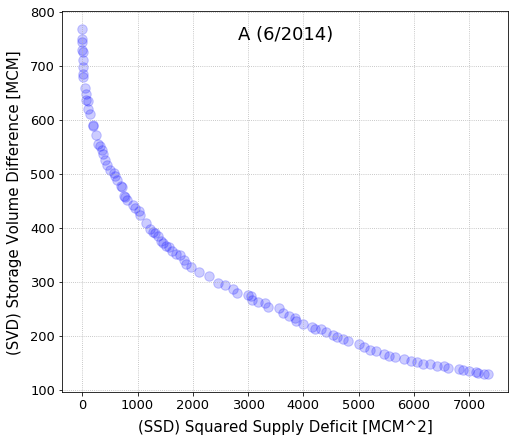

In [63]:
scenario = 5  # 1: Perfect forecast, 2: worst case, 3: 20year drought, 4: ESP, 5: SFFs

# So far, MCDM is not considered yet. It is just for the file name and directory.
MCDM = 2      # 1:'saw_bal', 2:'saw_sup', 3:'saw_sto', 4:'vw_select', 5:'vw_multi', 6:'rp_utopia', 7:'rp_knee', 8:'rp_topsis'

# Set the figure size and grid style
plt.figure(figsize=(8, 7))
plt.grid(True, axis='y', linestyle=':')  # Grid lines only on the y-axis
plt.grid(False, axis='x', linestyle=':')  # No grid lines on the x-axis

# Load the CSV file containing the simulation Pareto results for the given scenario and MCDM method
df = pd.read_csv(path + '/data/examples/' + scenario_list[scenario] + '/[sim_pareto]' + reservoir_name + '_' + str(year) + '_' + str(month) 
                   + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv')

# Create a scatter plot of SSD (Squared Supply Deficit) vs. SVD (Storage Volume Difference)
plt.scatter('SSD', 'SVD', data=df, color='blue', alpha=0.20, s=90)

plt.title(reservoir_name + ' (' + str(month) + '/' + str(year) + ')', x=0.5, y=0.91, fontsize=18) # Set the plot title
plt.xlabel('(SSD) Squared Supply Deficit [MCM^2]', fontsize=15, labelpad=8)  # Set the labels for the x axis
plt.ylabel('(SVD) Storage Volume Difference [MCM]', fontsize=15, labelpad=8) # Set the labels for the y axis
plt.tick_params(axis='x', labelsize=13)  # Adjust the size of the tick labels on both axes
plt.tick_params(axis='y', labelsize=13)

# Display the plot
plt.show()

In [17]:
from sklearn.preprocessing import MinMaxScaler


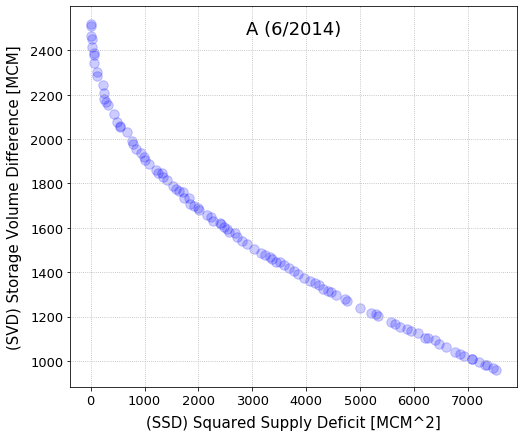

In [40]:
scenario = 2  # 1: Perfect forecast, 2: worst case, 3: 20year drought, 4: ESP, 5: SFFs

# So far, MCDM is not considered yet. It is just for the file name and directory.
MCDM = 1      # 1:'saw_bal', 2:'saw_sup', 3:'saw_sto', 4:'vw_select', 5:'vw_multi', 6:'rp_utopia', 7:'rp_knee', 8:'rp_topsis'

# Set the figure size and grid style
plt.figure(figsize=(8, 7))
plt.grid(True, axis='y', linestyle=':')  # Grid lines only on the y-axis
plt.grid(False, axis='x', linestyle=':')  # No grid lines on the x-axis

# Load the CSV file containing the simulation Pareto results for the given scenario and MCDM method
df = pd.read_csv(path + '/data/examples/' + scenario_list[scenario] + '/[sim_pareto]' + reservoir_name + '_' + str(year) + '_' + str(month) 
                   + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv')

# Create a scatter plot of SSD (Squared Supply Deficit) vs. SVD (Storage Volume Difference)
plt.scatter('SSD', 'SVD', data=df, color='blue', alpha=0.20, s=90)

plt.title(reservoir_name + ' (' + str(month) + '/' + str(year) + ')', x=0.5, y=0.91, fontsize=18) # Set the plot title
plt.xlabel('(SSD) Squared Supply Deficit [MCM^2]', fontsize=15, labelpad=8)  # Set the labels for the x axis
plt.ylabel('(SVD) Storage Volume Difference [MCM]', fontsize=15, labelpad=8) # Set the labels for the y axis
plt.tick_params(axis='x', labelsize=13)  # Adjust the size of the tick labels on both axes
plt.tick_params(axis='y', labelsize=13)

# Display the plot
plt.show()

In [41]:
# Weight allocation for SAW (Bal, Sup, Sto) and Simple Selective methods
weight_bal = 0.5    # Balanced weighting between supply and storage
weight_sup = 0.4    # Weight prioritizing supply (must be smaller than 0.5)
weight_sto = 0.6    # Weight prioritizing storage (must be larger than 0.5)

In [50]:
# Function for Simple Additive Weighting (SAW) method in Multi-Criteria Decision-Making (MCDM)
def MCDM_SAW_example(MCDM, year, month, reservoir_name, decision_time, leadtime):

    # Define file paths for different flow scenarios/forecasts
    path_pf = path + '/data/examples/' + scenario_list[1]   # Perfect forecast
    path_wc = path + '/data/examples/' + scenario_list[2]   # Worst-case
    path_d20 = path + '/data/examples/' + scenario_list[3] # 20-year return period drought
    path_esp = path + '/data/examples/' + scenario_list[4]  # ESP (Ensemble Streamflow Prediction)
    path_sffs = path + '/data/examples/' + scenario_list[5] # SFFs (Synthetic Flow Forecasts)

    # Read simulated Pareto front data for each flow scenario/forecast
    sim_pf = pd.read_csv(path_pf + '/[sim_pareto]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    sim_wc = pd.read_csv(path_wc + '/[sim_pareto]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    sim_d20 = pd.read_csv(path_d20 + '/[sim_pareto]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    sim_esp = pd.read_csv(path_esp + '/[sim_pareto]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    sim_sffs = pd.read_csv(path_sffs + '/[sim_pareto]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)

    # Normalization of the simulated Pareto front data
    scaler = MinMaxScaler()
    sim_all = pd.concat([sim_pf, sim_wc, sim_d20, sim_esp, sim_sffs], axis=0)  # Combine data from all scenarios
    nor_all = pd.DataFrame(scaler.fit(sim_all).transform(sim_all)).rename({0: 'SSD', 1: 'SVD'}, axis=1)  # Normalize data
    nor_all['number'] = nor_all.index  # Add index column for identification
    nor_all['remark'] = 'Perfect forecast'  # Default remark for Perfect forecast scenario
    
    # Assign appropriate remark labels for each scenario based on the index
    for i in range(len(nor_all)):
        if (nor_all['number'][i] >= 100) and (nor_all['number'][i] < 200):
            nor_all['remark'][i] = 'Worst-case'
            nor_all['number'][i] = nor_all['number'][i] - 100
        elif (nor_all['number'][i] >= 200) and (nor_all['number'][i] < 300):
            nor_all['remark'][i] = '20-year drought'
            nor_all['number'][i] = nor_all['number'][i] - 200
        elif (nor_all['number'][i] >= 300) and (nor_all['number'][i] < 400):
            nor_all['remark'][i] = 'ESP'
            nor_all['number'][i] = nor_all['number'][i] - 300
        elif (nor_all['number'][i] >= 400) and (nor_all['number'][i] < 500):
            nor_all['remark'][i] = 'SFFs'
            nor_all['number'][i] = nor_all['number'][i] - 400

    # Assign weight based on the selected MCDM method
    if MCDM == 1:  # Balanced method
        weight = weight_bal
    elif MCDM == 2:  # Supply prioritized method
        weight = weight_sup
    elif MCDM == 3:  # Storage prioritized method
        weight = weight_sto

    # Perfect forecast scenario
    nor_pf = nor_all[(nor_all.remark == 'Perfect forecast')]
    nor_pf['score'] = abs(nor_pf['SSD'] * (1 - weight) + nor_pf['SVD'] * weight)
    opt_num_pf = nor_pf[(nor_pf['score'] == nor_pf['score'].min())].index[0]  # Find optimal solution

    # Worst-case scenario
    nor_wc = nor_all[(nor_all.remark == 'Worst-case')]
    nor_wc['score'] = abs(nor_wc['SSD'] * (1 - weight) + nor_wc['SVD'] * weight)
    opt_num_wc = nor_wc[(nor_wc['score'] == nor_wc['score'].min())].index[0]  # Find optimal solution
    
    # 20-year return period drought scenario
    nor_d20 = nor_all[(nor_all.remark == '20-year drought')]
    nor_d20['score'] = abs(nor_d20['SSD'] * (1 - weight) + nor_d20['SVD'] * weight)
    opt_num_d20 = nor_d20[(nor_d20['score'] == nor_d20['score'].min())].index[0]  # Find optimal solution    

    # ESP scenario
    nor_esp = nor_all[(nor_all.remark == 'ESP')]
    nor_esp['sam'] = abs(nor_esp['SSD'] * (1 - weight) + nor_esp['SVD'] * weight)
    opt_num_esp = nor_esp[(nor_esp['sam'] == nor_esp['sam'].min())].index[0]  # Find optimal solution

    # SFFs scenario
    nor_sffs = nor_all[(nor_all.remark == 'SFFs')]
    nor_sffs['sam'] = abs(nor_sffs['SSD'] * (1 - weight) + nor_sffs['SVD'] * weight)
    opt_num_sffs = nor_sffs[(nor_sffs['sam'] == nor_sffs['sam'].min())].index[0]  # Find optimal solution

    # Read and prepare the data for output for each scenario
    pf = pd.read_csv(path_pf + '/[Res_operation]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    resop_pf = pf[str(opt_num_pf)]
    S_pf = pd.DataFrame(pf[str(opt_num_pf)].loc['Storage'])[:].rename(columns={str(opt_num_pf): 'S_pf'})[:decision_time * 4 + 1]

    wc = pd.read_csv(path_wc + '/[Res_operation]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    resop_wc = wc[str(opt_num_wc)]
    S_wc = pd.DataFrame(wc[str(opt_num_wc)].loc['Storage'])[:].rename(columns={str(opt_num_wc): 'S_wc'})[:decision_time * 4 + 1]

    d20 = pd.read_csv(path_d20 + '/[Res_operation]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    resop_d20 = d20[str(opt_num_d20)]
    S_d20 = pd.DataFrame(d20[str(opt_num_d20)].loc['Storage'])[:].rename(columns={str(opt_num_d20): 'S_d20'})[:decision_time * 4 + 1]
    
    esp = pd.read_csv(path_esp + '/[Res_operation]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    resop_esp = esp[str(opt_num_esp)]
    S_esp = pd.DataFrame(esp[str(opt_num_esp)].loc['Storage'])[:].rename(columns={str(opt_num_esp): 'S_esp'})[:decision_time * 4 + 1]

    sffs = pd.read_csv(path_sffs + '/[Res_operation]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    resop_sffs = sffs[str(opt_num_sffs)]
    S_sffs = pd.DataFrame(sffs[str(opt_num_sffs)].loc['Storage'])[:].rename(columns={str(opt_num_sffs): 'S_sffs'})[:decision_time * 4 + 1]

    # Concatenate all storage data into a single DataFrame
    S_all = pd.concat([S_pf, S_wc, S_d20, S_esp, S_sffs], axis=1).reset_index(drop=True)
    
    return S_all, opt_num_pf, opt_num_wc, opt_num_d20, opt_num_esp, opt_num_sffs

In [51]:
results = {}

for MCDM in [1, 2, 3]:
    # Call MCDM_SAW_example function for each MCDM method and store the results in the 'results' dictionary
    results[MCDM] = MCDM_SAW_example(MCDM, year, month, reservoir_name, decision_time, leadtime)

# Extract results for the Balanced method (MCDM 1), Supply prioritized method (MCDM 2) and Storage prioritized method (MCDM 3)
S_all1, opt_num_pf1, opt_num_wc1, opt_num_d201, opt_num_esp1, opt_num_sffs1 = results[1]
S_all2, opt_num_pf2, opt_num_wc2, opt_num_d202, opt_num_esp2, opt_num_sffs2 = results[2]
S_all3, opt_num_pf3, opt_num_wc3, opt_num_d203, opt_num_esp3, opt_num_sffs3 = results[3]

In [52]:
opt_num_pf

44

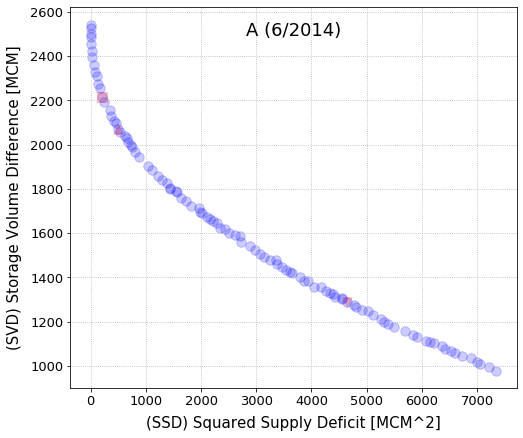

In [59]:
scenario = 2  # 1: Perfect forecast, 2: worst case, 3: 20year drought, 4: ESP, 5: SFFs

# So far, MCDM is not considered yet. It is just for the file name and directory.
MCDM = 2      # 1:'saw_bal', 2:'saw_sup', 3:'saw_sto', 4:'vw_select', 5:'vw_multi', 6:'rp_utopia', 7:'rp_knee', 8:'rp_topsis'

# Set the figure size and grid style
plt.figure(figsize=(8, 7))
plt.grid(True, axis='y', linestyle=':')  # Grid lines only on the y-axis
plt.grid(False, axis='x', linestyle=':')  # No grid lines on the x-axis

# Load the CSV file containing the simulation Pareto results for the given scenario and MCDM method
df = pd.read_csv(path + '/data/examples/' + scenario_list[scenario] + '/[sim_pareto]' + reservoir_name + '_' + str(year) + '_' + str(month) 
                   + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv')
bal = df.loc[df.index == opt_num_wc1]
sup = df.loc[df.index == opt_num_wc2]
sto = df.loc[df.index == opt_num_wc3]


# Create a scatter plot of SSD (Squared Supply Deficit) vs. SVD (Storage Volume Difference)
plt.scatter('SSD', 'SVD', data=df, color='blue', alpha=0.20, s=90)

plt.scatter('SSD', 'SVD', data=bal, color='red', alpha=0.20, s=90, marker='s')
plt.scatter('SSD', 'SVD', data=sup, color='red', alpha=0.20, s=90, marker='^')
plt.scatter('SSD', 'SVD', data=sto, color='red', alpha=0.20, s=90, marker='v')

plt.title(reservoir_name + ' (' + str(month) + '/' + str(year) + ')', x=0.5, y=0.91, fontsize=18) # Set the plot title
plt.xlabel('(SSD) Squared Supply Deficit [MCM^2]', fontsize=15, labelpad=8)  # Set the labels for the x axis
plt.ylabel('(SVD) Storage Volume Difference [MCM]', fontsize=15, labelpad=8) # Set the labels for the y axis
plt.tick_params(axis='x', labelsize=13)  # Adjust the size of the tick labels on both axes
plt.tick_params(axis='y', labelsize=13)

# Display the plot
plt.show()

In [60]:
bal

,Unnamed: 0,SSD,SVD
15,15,212.350752,2215.062839


In [61]:
sto

,Unnamed: 0,SSD,SVD
17,17,4641.417044,1288.838558


In [62]:
sup

,Unnamed: 0,SSD,SVD
43,43,488.543446,2068.80075


In [58]:
df.head(20)

,Unnamed: 0,SSD,SVD
0,0,7529.035246,961.430848
1,1,0.000000,2520.394255
2,2,435.773359,2111.774954
3,3,681.189217,2033.653134
4,4,228.187822,2243.936455
5,5,6599.882178,1061.507966
6,6,326.092943,2153.134811
7,7,64.823998,2342.640980
8,8,1088.355564,1889.738769
9,9,6759.944965,1042.079374
